In [1]:
# Get real-time GPU usage and memory stats
!gpustat

/bin/bash: gpustat: command not found


In [2]:
# Standard library imports
import json
import sys
import time
import warnings
from io import BytesIO

# Third-party imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image, to_tensor
from torchvision.utils import make_grid

# Disable gradient computation
torch.autograd.set_grad_enabled(False)

# Set the current CUDA device
torch.cuda.set_device(0)

# Add specified paths to sys.path
sys.path.append('/root/autodl-tmp/DC-FAE')
sys.path.append('/root/autodl-tmp/DC-FAE/models/stylegan2')

import tqdm

# Local application imports
from models.decoder import StyleGANDecoder  # For generating images
from models.e4e.psp_encoders import Encoder4Editing  # Encoder model for generating encoding w
from models.modules import ANT, Classifier  # Models including classifier and ANT
from models.ops import load_network, age2group  # Functions for loading network and converting age to group

In [ ]:
# File paths
stylegan2_checkpoint = '/root/autodl-tmp/DC-FAE/data/ffhq.pkl'
e4e_checkpoint = '/root/autodl-tmp/DC-FAE/data/e4e_ffhq_encode.pt'
classifier_checkpoint = '/root/autodl-tmp/DC-FAE/data/focal_loss_r50_age_8410.pth'
realnvp_checkpoint = '/root/autodl-tmp/DC-FAE/data/realnvp.pth'

# Initialize the StyleGANDecoder (decoder)
G = StyleGANDecoder(
    stylegan2_checkpoint,
    start_from_latent_avg=False,  # Whether to start from the latent average
    output_size=256,  # Output image size (256x256)
).eval().cuda()  # Switch to evaluation mode and move to GPU

# Initialize the Encoder4Editing model
encoder = Encoder4Editing(
    50,
    'ir_se',
    stylegan_size=1024,
    checkpoint_path=e4e_checkpoint
).eval().cuda()

# Initialize the Classifier model
image_classifier = Classifier(backbone='r50').eval().cuda()

# Load pretrained classifier weights
image_classifier.load_state_dict(
    load_network(
        torch.load(classifier_checkpoint, map_location='cpu')
    )
)

# Import models for additional loss calculations
from models.ops.lpips import LPIPS  # LPIPS for perceptual image similarity
from models.ops.loss import IDLoss  # Identity loss to ensure consistency in generated images
from models.modules import FLOW  # RealNVP flow model

# Initialize the LPIPS model for perceptual loss
LIPIPS_LOSS = LPIPS().cuda()

# Initialize IDLoss for identity-related loss
ID_LOSS = IDLoss(crop=True, backbone='mobilefacenet').cuda()

# Initialize the RealNVP model
realnvp = FLOW(style_dim=G.style_dim, n_styles=G.n_styles, n_layer=10).cuda().eval()
realnvp.load_state_dict(torch.load(realnvp_checkpoint, map_location='cpu'))

In [4]:
# Import necessary modules
from torchvision import transforms
from models.dataset import dataset_dict
from models.ops import dataset_with_indices, age2group

# Set image size and batch size
img_size = 256
bs = 8

# Define normalization transform
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)

# Compose test transforms
test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    normalize  # Normalize image
])

# Select dataset type and define data root
dataset_type = dataset_dict['FFHQAge']
data_root = '/root/autodl-tmp/DATASET/FFHQ/images256x256'

# Instantiate test dataset
test_dataset = dataset_type(data_root, img_size=img_size, split='test', transform=test_transform)

# Instantiate DataLoader
test_loader = torch.utils.data.DataLoader(
    dataset_with_indices(test_dataset),  # Wrap dataset with indices
    batch_size=bs,
    shuffle=False,  # No need to shuffle for testing
    num_workers=8
)

In [5]:
# Empty list to store latent representations of all test samples
all_latents = []

# Iterate over each batch in test_loader
for (images, _), _ in tqdm.tqdm(test_loader):
    images = images.cuda()

    # Prevent gradient computation for inference
    with torch.no_grad():
        # Get latent representation of images using encoder and append to list
        all_latents.append(encoder(images))

# Concatenate all latent representations into a single tensor
all_latents = torch.cat(all_latents, dim=0)

# Empty list to store model predictions for all test samples
all_preds = []

# Iterate over each batch in test_loader again
for (images, _), _ in tqdm.tqdm(test_loader):
    images = images.cuda()

    with torch.no_grad():
        image_classifier.eval()  # Set the model to evaluation mode
        # Get model predictions and apply sigmoid to get probabilities
        preds = image_classifier(images)[0].sigmoid()
        all_preds.append(preds)

# Concatenate all predictions into a single tensor
all_preds = torch.cat(all_preds, dim=0)

# Add latent average (latent_avg) to each latent representation
all_real_latents = all_latents + G.latent_avg

# Binarize predictions (values > 0.5 become 1, else 0)
all_real_preds = (all_preds > 0.5).float()

100%|██████████| 98/98 [00:06<00:00, 16.18it/s]


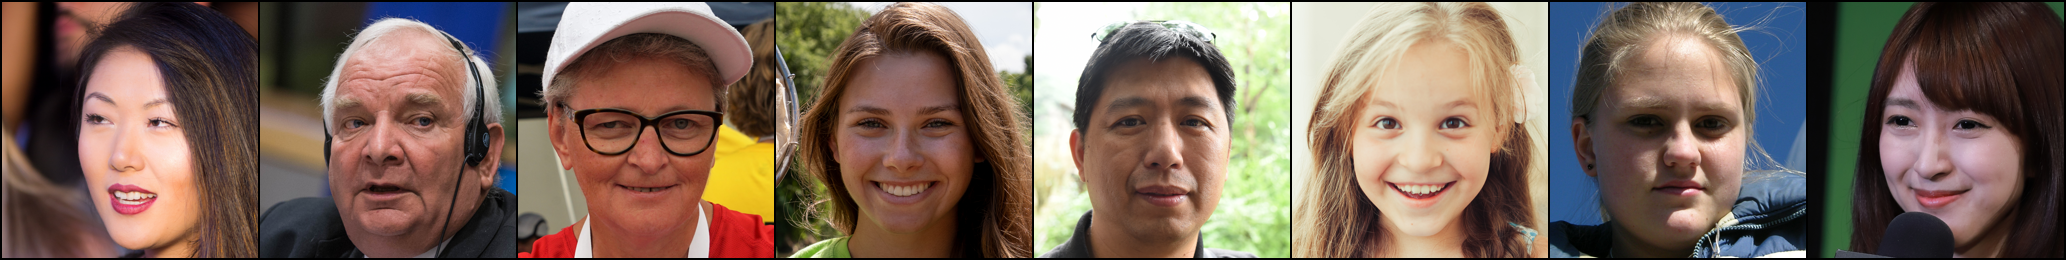

In [6]:
# Get the first image batch, convert pixel values to [0, 1] range for visualization
to_pil_image(make_grid(next(iter(test_loader))[0][0] * 0.5 + 0.5))

In [7]:
all_preds[:8]

tensor([[7.2397e-03, 6.6875e-01, 5.6621e-01, 6.3914e-02, 4.7831e-02, 1.9375e-02,
         5.0196e-01, 1.2666e-01, 3.1841e-01, 2.6363e-03, 1.2978e-08, 5.5008e-01,
         2.0114e-01, 5.5441e-01, 2.5759e-01, 3.3125e-02, 2.4379e-02, 1.7711e-05,
         9.1796e-01, 6.8541e-01, 1.9739e-05, 9.9647e-01, 1.9981e-02, 6.7608e-01,
         9.3763e-01, 4.5554e-01, 9.6490e-02, 3.1869e-01, 1.6962e-01, 4.1264e-01,
         1.0863e-03, 7.9989e-01, 7.2575e-01, 3.4938e-01, 3.4588e-01, 1.0708e-02,
         9.9982e-01, 4.1909e-01, 3.6538e-02, 9.4452e-01, 1.0000e+00, 9.9989e-01,
         1.3434e-04, 4.6845e-08, 5.0111e-10, 3.0151e-08],
        [9.4474e-02, 4.8967e-01, 1.1498e-02, 8.2161e-01, 6.7014e-01, 2.2166e-02,
         1.6304e-01, 9.4413e-01, 3.2208e-03, 5.1213e-02, 6.7796e-05, 4.6835e-02,
         1.1687e-01, 9.4289e-01, 9.5669e-01, 1.6590e-02, 6.7256e-02, 7.9633e-01,
         1.5231e-03, 5.8770e-01, 9.8355e-01, 6.3817e-01, 9.3179e-02, 4.0395e-01,
         5.6453e-01, 1.8113e-01, 1.7372e-03, 2.8997

In [8]:
import os

# Add the directory where 'ninja' is located to the PATH environment variable
os.environ['PATH'] = '/root/miniconda3/envs/adatrans/bin:' + os.environ['PATH']

# Check if the PATH environment variable is set correctly
print(os.environ['PATH'])

/root/miniconda3/envs/adatrans/bin:/root/miniconda3/bin:/usr/local/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin


Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


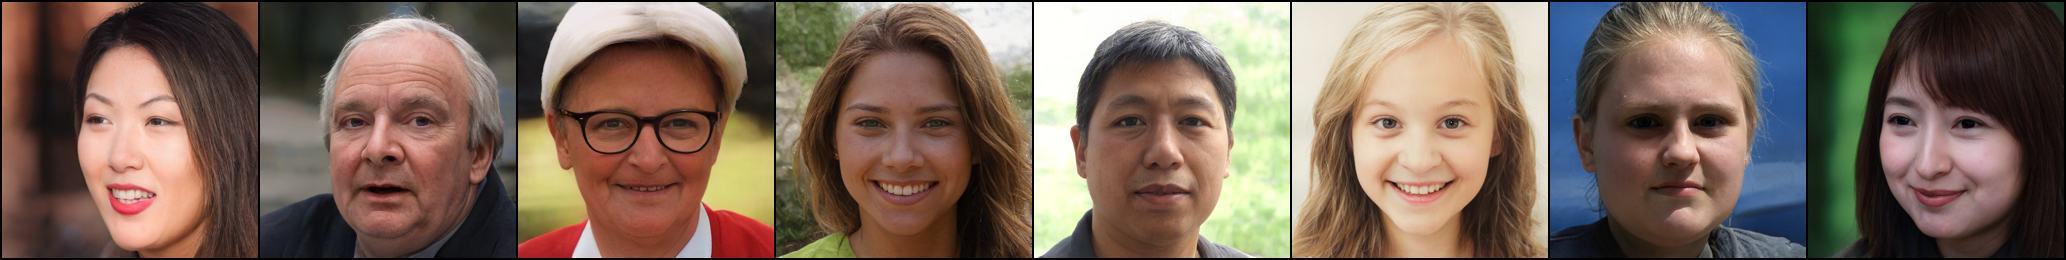

In [9]:
to_pil_image(make_grid(G(all_real_latents[:8]).clamp(-1, 1) * 0.5 + 0.5))

In [10]:
# Define transformer parameters in a dictionary
transformer_params = {
    'd_model': 512,
    'nhead': 4,
    'num_layers': 3
}

In [11]:
class LatentAdaTrans(object):
    def __init__(self, attr_num, checkpoint, scale=1.0):
        self.attr_num = attr_num
        self.scale = scale

        # Initialize the ANT model with given parameters
        model = ANT(
            c_dim=1,
            max_steps=10,
            n_layers=10,
            hid_dim=512,
            n_styles=G.n_styles,
            style_dim=G.style_dim,
            transformer_params=transformer_params
        ).eval().cuda()

        # Load model weights from checkpoint
        model.load_state_dict(load_network(torch.load(checkpoint, map_location='cpu')))
        self.model = model

        # Set max_steps based on the scale parameter
        self.model.max_steps = int(scale)

    def transform(self, inputs, sources):
        # Calculate the target values based on the attribute number
        targets_ = 1 - (sources[:, self.attr_num] > 0.5).float()
        targets_[targets_ == 0] = -1.

        # Generate the trajectory and step size using the model
        trajectory, step_size = self.model(inputs, targets_.unsqueeze(1))

        # Get the new styles from the trajectory
        new_styles = trajectory[-1]

        return new_styles

In [12]:
model_type = LatentAdaTrans
attr_num = 15
scale = 5.0

transformer = model_type(
    attr_num=attr_num,
    checkpoint='/root/autodl-tmp/DC-FAE/training/compressed_ckpt/15_1221/save_models/student-3200',
    scale=scale
)

tensor(109, device='cuda:0')


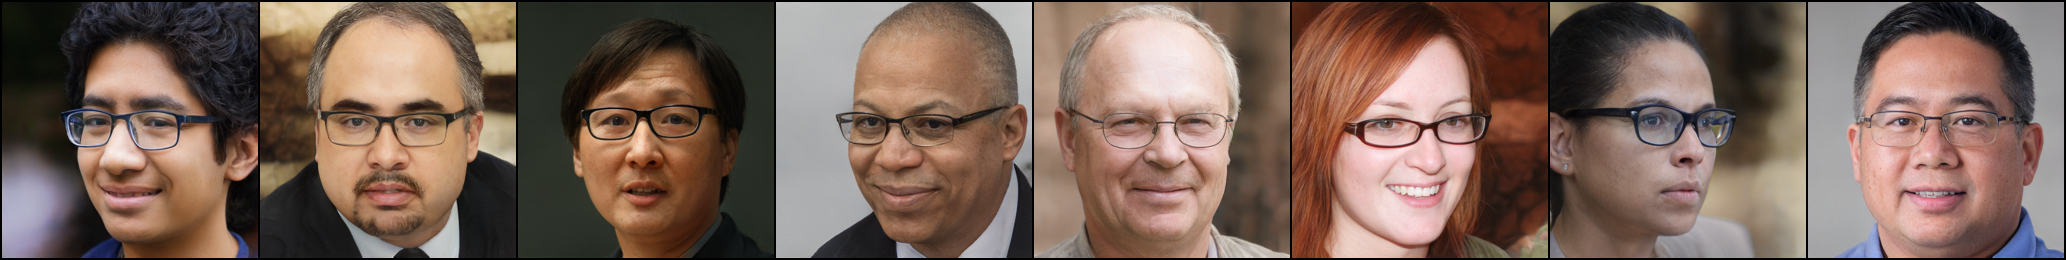

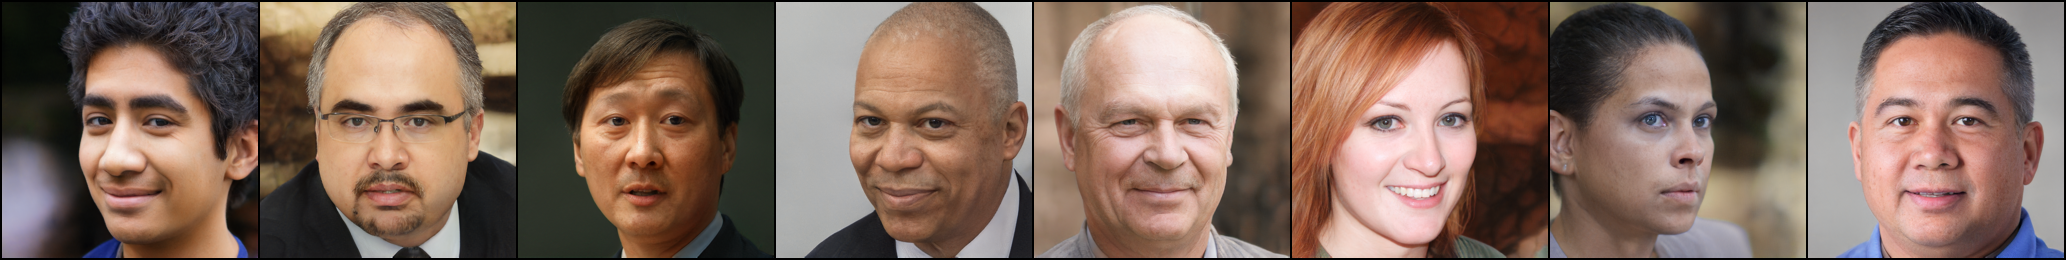

In [13]:
from IPython.display import display

# Create a mask where the 15th attribute is equal to 1.0
mask = all_real_preds[:, 15] == 1.0

# Print the number of elements that match the mask condition
print(mask.sum())

# Create a tensor of indices and apply the mask
indices = torch.arange(len(all_real_preds)).cuda()
indices = indices[mask][torch.arange(8) + 4]

# Display the original images generated by G
original_images = G(all_real_latents[indices]).clamp(-1, 1) * 0.5 + 0.5
display(to_pil_image(make_grid(original_images)))

# Apply the transformer to the latent space and display the transformed images
transformed_images = G(
    transformer.transform(all_real_latents[indices], all_real_preds[indices])
).clamp(-1, 1) * 0.5 + 0.5
display(to_pil_image(make_grid(transformed_images)))

In [14]:
def eval_single_attr(transformer):
    id_loss = 0.0
    total = 0.0
    all_editing_preds = []
    ll = 0.0

    # Loop through the test loader and evaluate
    for (images, _), indices in tqdm.tqdm(test_loader):
        images = images.cuda()
        bs = images.size(0)

        # Get latent vectors and source predictions for the batch
        latents = all_real_latents[indices]
        sources = all_real_preds[indices]

        # Apply transformation and generate new images
        new_styles = transformer.transform(latents, sources)
        new_images = G(new_styles).clamp(-1, 1)

        # Calculate identity loss and update total
        id_loss += ID_LOSS(images, new_images).item() * bs
        total += bs

        # Store the predictions after transformation
        all_editing_preds.append(torch.sigmoid(image_classifier(new_images)[0]))

        # Evaluate log-likelihood with realnvp
        realnvp.eval()
        ll += realnvp(new_styles)[0] * bs

    # Combine and threshold predictions to get final binary results
    all_editing_preds = (torch.cat(all_editing_preds, dim=0) > 0.5).float()

    # Return the averaged identity loss, editing predictions, and log-likelihood
    return id_loss / total, all_editing_preds, ll / total

In [15]:
# Initialize scales (scaled by 5)
scales = np.arange(0.2, 3.1, 0.2) * 5

# List of attribute indices to edit
attr_lis = [15, 20, 39]

# List of checkpoints for different attributes
checkpoints = [
    '/root/autodl-tmp/DC-FAE/training/compressed_ckpt/15_1221/save_models/student-3200',
    '/root/autodl-tmp/DC-FAE/training/compressed_ckpt/20_1221/save_models/student-6800',
    '/root/autodl-tmp/DC-FAE/training/compressed_ckpt/39_1221/save_models/student-4800'
]

# Dictionary to store results
results = {}

# Precompute remaining attribute indices for each attribute
remaining_attr_indices_list = [
    [attr for attr in attr_lis if attr != attr_num]
    for attr_num in attr_lis
]

# Loop over each scale
for scale in scales:
    # Initialize lists to store intermediate results
    all_id_loss, all_editing_acc, all_attr_preserve_acc, all_ll = [], [], [], []

    # Loop over each attribute in attr_lis
    for i, attr_num in enumerate(attr_lis):
        # Get remaining attribute indices for this attribute
        remaining_attr_indices = remaining_attr_indices_list[i]

        # Initialize the transformer model with the current attribute and scale
        transformer = model_type(
            attr_num=attr_num,
            checkpoint=checkpoints[i],
            # retained_attr_indices=remaining_attr_indices,
            scale=scale
        )

        # Evaluate the model on this attribute
        id_loss, all_editing_preds, ll = eval_single_attr(transformer)

        # Calculate editing accuracy for the specific attribute
        editing_acc = (all_editing_preds[:, attr_num] == 1 - all_real_preds[:, attr_num]).float().mean().cpu().item()

        # Calculate attribute preservation accuracy for remaining attributes
        attr_preserve_acc = (
                all_editing_preds[:, remaining_attr_indices] == all_real_preds[:, remaining_attr_indices]
        ).float().mean(dim=0).cpu().numpy()

        # Append results to the lists
        all_id_loss.append(id_loss)
        all_editing_acc.append(editing_acc)
        all_attr_preserve_acc.append(attr_preserve_acc)
        all_ll.append(ll.item())

    # Compute mean of results for this scale
    mean_editing_acc = np.mean(all_editing_acc)
    mean_attr_preserve_acc = np.mean(all_attr_preserve_acc)
    mean_id_loss = np.mean(all_id_loss)
    mean_ll = np.mean(all_ll)

    # Display results for the current scale
    display(scale, mean_editing_acc, mean_attr_preserve_acc, mean_id_loss, mean_ll)

    # Store the results in a dictionary
    results[float(scale)] = {
        'editing_acc': float(mean_editing_acc),
        'attr_preserve_acc': float(mean_attr_preserve_acc),
        'id_loss': float(mean_id_loss),
        'll': float(mean_ll),
    }

100%|██████████| 98/98 [00:12<00:00,  7.78it/s]


1.0

0.23080223550399145

0.94165593

-0.7942664146116495

-0.07240880032380421

100%|██████████| 98/98 [00:13<00:00,  7.48it/s]


2.0

0.5263835291067759

0.9339339

-0.7500334966085541

-0.05966216574112574

100%|██████████| 98/98 [00:13<00:00,  7.23it/s]


3.0000000000000004

0.7498927712440491

0.92213637

-0.7029259359565532

-0.04329744726419449

100%|██████████| 98/98 [00:14<00:00,  6.89it/s]


4.0

0.8807379007339478

0.91205496

-0.660678053352261

-0.023585280558715265

100%|██████████| 98/98 [00:14<00:00,  6.70it/s]


5.0

0.951522946357727

0.90304595

-0.6217129052017749

-1.7092640822132427e-05

100%|██████████| 98/98 [00:15<00:00,  6.50it/s]


6.0

0.9824110070864359

0.90004283

-0.586485776789758

0.026010234529773395

100%|██████████| 98/98 [00:15<00:00,  6.32it/s]


7.000000000000001

0.990133007367452

0.8970399

-0.5547945775708535

0.05341382293651501

100%|██████████| 98/98 [00:16<00:00,  6.12it/s]


8.0

0.9935650030771891

0.89232093

-0.5260307898545971

0.0812255433217312

100%|██████████| 98/98 [00:16<00:00,  5.89it/s]


9.0

0.9948520064353943

0.8891034

-0.5014811629059488

0.10858909568438928

100%|██████████| 98/98 [00:17<00:00,  5.61it/s]


10.0

0.9952810009320577

0.8888889

-0.47984443954621603

0.1350869257003069

100%|██████████| 98/98 [00:17<00:00,  5.63it/s]


11.0

0.9965680042902628

0.88095236

-0.4598902514542392

0.16148287430405617

100%|██████████| 98/98 [00:17<00:00,  5.47it/s]


12.000000000000002

0.9969969987869263

0.8738739

-0.44096153276460665

0.1883243645230929

100%|██████████| 98/98 [00:18<00:00,  5.25it/s]


13.000000000000004

0.9974260131518046

0.8646504

-0.4225158205440452

0.21567726135253906

100%|██████████| 98/98 [00:18<00:00,  5.17it/s]


14.000000000000002

0.997855007648468

0.8599314

-0.40545560675263664

0.24364889164765677

100%|██████████| 98/98 [00:19<00:00,  5.04it/s]


15.000000000000002

0.9974260131518046

0.8498499

-0.38888750958217666

0.27224789808193844

In [16]:
print(results)

{1.0: {'editing_acc': 0.23080223550399145, 'attr_preserve_acc': 0.9416559338569641, 'id_loss': -0.7942664146116495, 'll': -0.07240880032380421}, 2.0: {'editing_acc': 0.5263835291067759, 'attr_preserve_acc': 0.9339339137077332, 'id_loss': -0.7500334966085541, 'll': -0.05966216574112574}, 3.0000000000000004: {'editing_acc': 0.7498927712440491, 'attr_preserve_acc': 0.9221363663673401, 'id_loss': -0.7029259359565532, 'll': -0.04329744726419449}, 4.0: {'editing_acc': 0.8807379007339478, 'attr_preserve_acc': 0.9120549559593201, 'id_loss': -0.660678053352261, 'll': -0.023585280558715265}, 5.0: {'editing_acc': 0.951522946357727, 'attr_preserve_acc': 0.9030459523200989, 'id_loss': -0.6217129052017749, 'll': -1.7092640822132427e-05}, 6.0: {'editing_acc': 0.9824110070864359, 'attr_preserve_acc': 0.9000428318977356, 'id_loss': -0.586485776789758, 'll': 0.026010234529773395}, 7.000000000000001: {'editing_acc': 0.990133007367452, 'attr_preserve_acc': 0.8970398902893066, 'id_loss': -0.554794577570853

<Axes: >

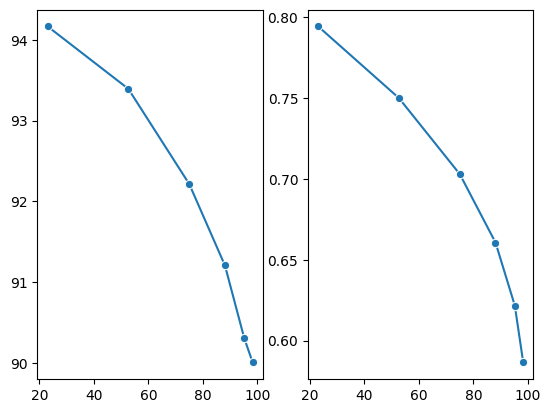

In [18]:
import seaborn as sns

# Extract data from the results
x = np.array([results[k]['editing_acc'] for k in results])
y1 = np.array([results[k]['attr_preserve_acc'] for k in results])
y2 = np.array([results[k]['id_loss'] for k in results])

# Apply mask and adjust values
mask = x <= 0.99
x = x[mask] * 100
y1 = y1[mask] * 100
y2 = -y2[mask]

# Plot the data
plt.subplot(1, 2, 1)
sns.lineplot(x=x, y=y1, marker='o')

plt.subplot(1, 2, 2)
sns.lineplot(x=x, y=y2, marker='o')